In [27]:
using GraphViz

using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz

In [28]:
# Functions for graphing typed Petri nets
colors_vflow = ["antiquewhite4","antiquewhite", "gold", "saddlebrown", "slateblue", "blueviolet", "olive"]
colors_s = ["deeppink","darkorchid","darkred","coral"] # red series
colors_sv = ["cornflowerblue","cyan4","cyan","chartreuse"] # green and blue series
colors_p = ["gold","gold4","darkorange1","lightgoldenrod","goldenrod"] # yellow and orange

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(typed_StockFlow::ACSetTransformation, colors) = 
  (p,s) -> ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square", 
                                     :color=>"black", 
                                     :style=>"filled", 
                                     :fillcolor=>colors[typed_StockFlow[:S](s)]))

def_parameter(typed_StockFlow::ACSetTransformation, colors) = 
(p, pp) -> ("p$pp", Attributes(:label=>pname(p,pp) isa Tuple where T ? Html(replace(string(pname(p,pp)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(pname(p,pp))",
                                     :shape=>"circle", 
                                     :color=>colors[typed_StockFlow[:P](pp)],
                                     :fontcolor=>colors[typed_StockFlow[:P](pp)]))

def_auxiliaryVF(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>make_v_expr(p,v) isa Tuple where T ? Html(replace(string(make_v_expr(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(make_v_expr(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[typed_StockFlow[:V](v)]))


def_sumV(typed_StockFlow::ACSetTransformation, colors) = 
  (p, sv) -> ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle", 
                                       :color=>"black",
                                       :fillcolor=>colors[typed_StockFlow[:SV](sv)], 
                                       :style=>"filled"))  


def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
end
        
def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, f) -> begin
     colorType = colors[typed_StockFlow[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors_vflow)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
    
end
        
def_flow_noneV(colors = colors_vflow)=
  (p, us, ds, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

GraphF_typed(typed_StockFlow::ACSetTransformation, colors_vflow = colors_vflow, colors_s = colors_s, colors_p = colors_p, colors_sv = colors_sv; schema::String="C", type::String="SFVL", rd::String="LR") = GraphF(dom(typed_StockFlow),
    make_stock = def_stock(typed_StockFlow, colors_s), make_auxiliaryV=def_auxiliaryVF(typed_StockFlow, colors_vflow), make_sumV=def_sumV(typed_StockFlow, colors_sv), 
    make_flow_V=def_flow_V(typed_StockFlow, colors_vflow), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors_vflow),make_parameter=def_parameter(typed_StockFlow, colors_p),schema=schema, type=type, rd=rd
)

GraphF_typed (generic function with 5 methods)

In [33]:
SIR = @stock_and_flow begin
    :stocks
    S
    I
    R
    
    :parameters
    c
    β
    tRec
    
    :dynamic_variables
    v_prevalence = I / N
    v_meanInfectiousContactsPerS = c * v_prevalence
    v_perSIncidenceRate = β * v_meanInfectiousContactsPerS
    v_newInfections = S * v_perSIncidenceRate
    v_newRecovery = I / tRec
    
    :flows
    S => f_inf(v_newInfections) => I
    I => f_rec(v_newRecovery) => R
    
    
    :sums
    N = [S, I, R]
    
    
end;


In [52]:
# ACSetTransformation(ageWeightModel, l_type,
#   S = [s,s,s],
#   SV = [N],
#   LS = [lsn,lsn,lsn],   
#   F = [f_birth, f_fstorder, f_death, f_aging, f_fstorder, f_death, f_aging, f_fstorder, f_death],    
#   I = [i_birth, i_fstorder, i_aging, i_fstorder, i_aging, i_fstorder], 
# O = [o_fstorder, o_death, o_aging, o_fstorder, o_death, o_aging, o_fstorder, o_death],
# V = [v_birth, v_death, v_fstorder, v_aging, v_death, v_fstorder, v_aging, v_death, v_fstorder],
#   LV = [lv_death1, lv_fstorder1, lv_aging1, lv_death1, lv_fstorder1, lv_aging1, lv_death1, lv_fstorder1],
#   LSV = [lsv_birth1],
#   P = [p_μ, p_δ, p_δ, p_δ, p_rage, p_rage, p_rfstOrder],
#   LPV = [lpv_birth2, lpv_death2, lpv_fstorder2, lpv_aging2, lpv_death2, lpv_fstorder2, lpv_aging2, lpv_death2, lpv_fstorder2],
#   Name = name -> nothing, Op=op->nothing, Position=pos->nothing
# );



identity_sir = ACSetTransformation(SIR, SIR,
    S = parts(SIR, :S),
    SV = parts(SIR, :SV),
    LS = parts(SIR, :LV),
    F = parts(SIR, :F),
    I = parts(SIR, :I),
    O = parts(SIR, :O),
    V = parts(SIR, :V),
    LV = parts(SIR, :LV),
    LSV = parts(SIR, :LSV),
    LVV = parts(SIR, :LVV),
    P = parts(SIR, :P),
    LPV = parts(SIR, :LPV),
    Name = Op = Position = k -> nothing
#     Name =  k -> getfield(SIR, :subparts)[:vname],
#     Op = k -> getfield(SIR, :subparts)[:vop],
#     Position =  k -> getfield(SIR, :subparts)[:vop],
)

ACSetTransformation((S = FinFunction(1:3, 3, 3), SV = FinFunction(1:1, 1, 1), LS = FinFunction(1:3, 3, 3), F = FinFunction(1:2, 2, 2), I = FinFunction(1:2, 2, 2), O = FinFunction(1:2, 2, 2), V = FinFunction(1:5, 5, 5), LV = FinFunction(1:3, 3, 3), LSV = FinFunction(1:1, 1, 1), P = FinFunction(1:3, 3, 3), LVV = FinFunction(1:3, 3, 3), LPV = FinFunction(1:3, 3, 3), Name = SetFunction(#140, TypeSet(Symbol), TypeSet(Symbol)), Op = id(TypeSet(Symbol)), Position = id(TypeSet(Int8))), StockAndFlowF {S = 3, SV = 1, LS = 3, F = 2, I = 2, O = 2, V = 5, LV = 3, LSV = 1, P = 3, LVV = 3, LPV = 3}, StockAndFlowF {S = 3, SV = 1, LS = 3, F = 2, I = 2, O = 2, V = 5, LV = 3, LSV = 1, P = 3, LVV = 3, LPV = 3})

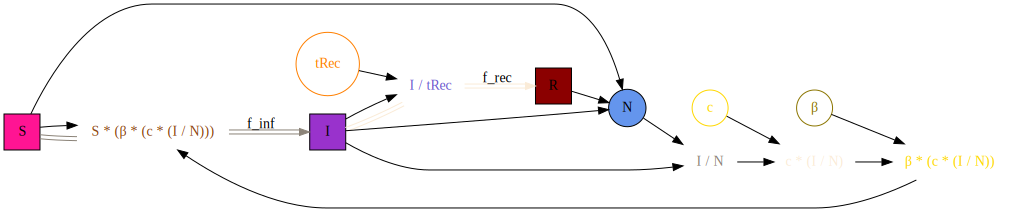

In [53]:
GraphF_typed(identity_sir)